In [ ]:
import os
import random
import shutil
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from  IPython import display

plt.rcParams['figure.figsize'] = (12, 8)
print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
GPU is available


In [ ]:
PATH = '/content'
DATA_PATH = '/content/drive/MyDrive/Datasets/complete_xdcms'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_dataset_size(path):
    num_of_images = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        num_images_in_folder = len(os.listdir(folder_path))
        num_of_images[folder] = num_images_in_folder
    return num_of_images

In [ ]:
new_dataset_size = get_dataset_size(DATA_PATH)
print('New Dataset Size:', new_dataset_size)

New Dataset Size: {'Cancer': 477, 'Non-Cancer': 395}


In [ ]:
def preprocess_images(input_dir, output_dir, target_size=(256, 256)):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    classes = os.listdir(input_dir)
    for class_name in classes:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue


        output_class_path = os.path.join(output_dir, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        images = os.listdir(class_path)
        for image_name in images:
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, target_size)

            output_image_path = os.path.join(output_class_path, image_name)
            cv2.imwrite(output_image_path, image)
    print("Preprocessing completed.")


input_directory = DATA_PATH
output_directory = '/content/dataset'
preprocess_images(input_directory, output_directory)

Preprocessing completed.


In [ ]:
PATH = '/content'
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.chdir(PATH)
    IMAGES_PATH = PATH +'/images'

    if os.path.isdir(IMAGES_PATH) is False:
        os.mkdir('images')
        IMAGES_PATH = PATH + '/images'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)

    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [ ]:
def plot_images(path, num_images=16, figsize=(8, 8), save_id=None):
    images = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            images.append((image_path, folder))

    plt.figure(figsize=figsize)
    for i in range(num_images):
        random_img = random.choice(images)
        img = plt.imread(random_img[0])
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.title(random_img[1])
        plt.imshow(img)

    plt.tight_layout()

    if save_id is not None:
        save_fig(save_id)
    plt.show()


Saving figure images_org


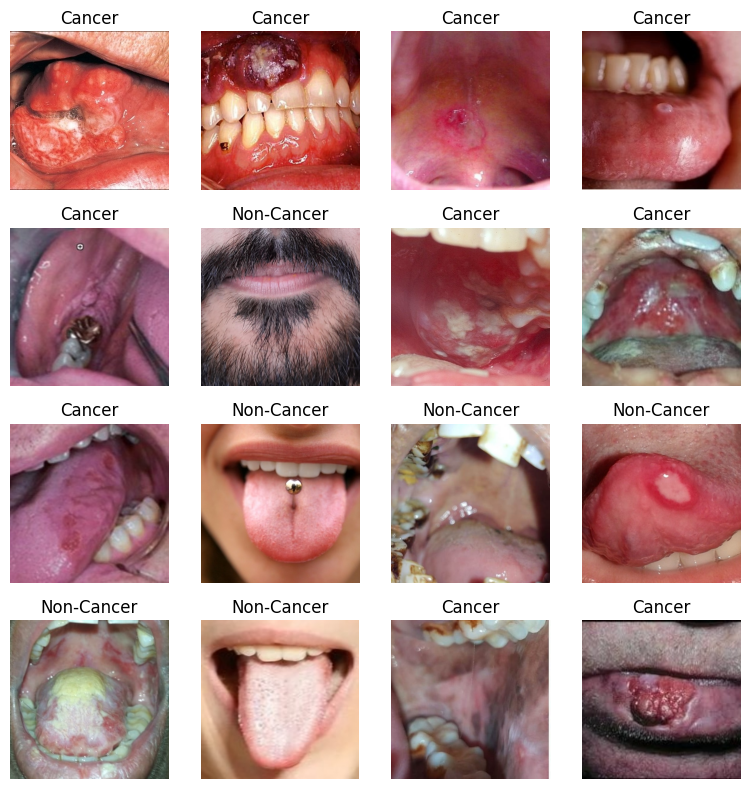

In [ ]:
plot_images(DATA_PATH, save_id='images_org')

Saving figure images_proc


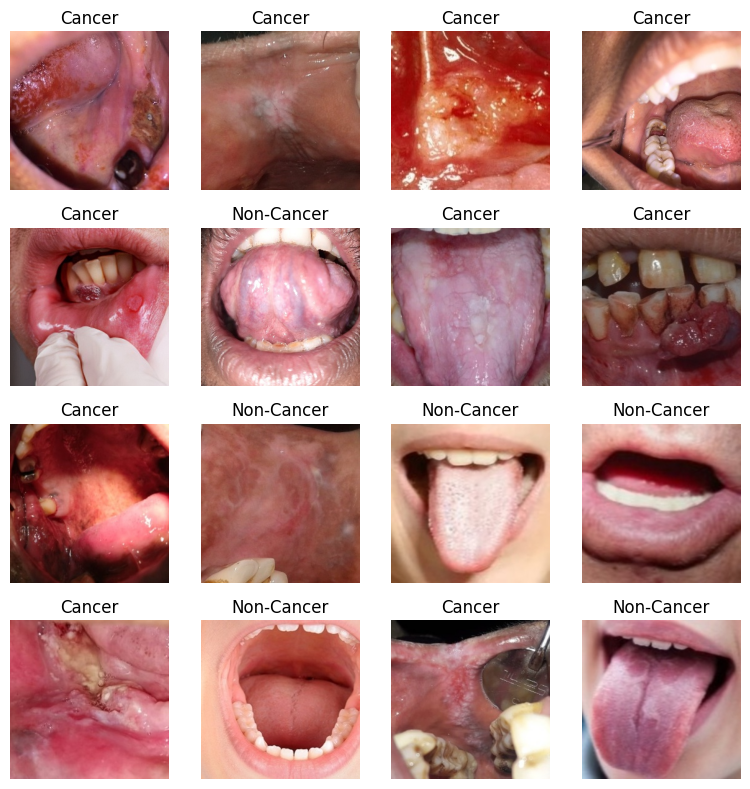

In [ ]:
plot_images('/content/dataset', save_id='images_proc')

In [ ]:
def train_val_test_split(root_dir, classes_dir,new_dir, val_ratio=0.25, test_ratio=0.15):
    os.mkdir(new_dir)
    os.chdir(new_dir)

    for cls in classes_dir:

        os.makedirs('train/' + cls, exist_ok=True)
        os.makedirs('val/' + cls, exist_ok=True)
        os.makedirs('test/' + cls, exist_ok=True)

        src = os.path.join(root_dir, cls)
        all_file_names = os.listdir(src)
        np.random.shuffle(all_file_names)

        num_images = len(all_file_names)
        num_val = int(num_images * val_ratio)
        num_test = int(num_images * test_ratio)
        num_train = num_images - num_val - num_test

        train_file_names = all_file_names[:num_train]
        val_file_names = all_file_names[num_train:num_train + num_val]
        test_file_names = all_file_names[num_train + num_val:]

        print(f"{cls.upper()}:")
        print('Total images: ', num_images)
        print('Training: ', len(train_file_names))
        print('Validation: ', len(val_file_names))
        print('Testing: ', len(test_file_names))


        for name in train_file_names:
            shutil.copy(os.path.join(src, name), os.path.join('train', cls))

        for name in val_file_names:
            shutil.copy(os.path.join(src, name), os.path.join('val', cls))

        for name in test_file_names:
            shutil.copy(os.path.join(src, name), os.path.join('test', cls))
        print()

In [ ]:
root_dir = '/content/dataset'
new_dir = '/content/splitted_dataset'
classes_dir = ['Cancer', 'Non-Cancer']
train_val_test_split(root_dir, classes_dir ,new_dir)

CANCER:
Total images:  477
Training:  287
Validation:  119
Testing:  71

NON-CANCER:
Total images:  395
Training:  238
Validation:  98
Testing:  59



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape=(256, 256, 3)):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())


    model.add(Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())


    model.add(Dropout(rate=0.5))
    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                      

In [ ]:
from math import ceil
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

def image_data_generator(data_dir,class_weights=None):

    datagen = image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
        )


    return datagen.flow_from_directory(
        directory=data_dir,
        target_size=(256,256),
        batch_size=16,
        class_mode='binary',
        shuffle = True
    )

def train_model_with_data_generators(model, train_dir, val_dir, epochs=32,class_weight=None):

    train_data = image_data_generator(train_dir)
    val_data = image_data_generator(val_dir)

    print("Train Data:")
    print("Found", train_data.samples, "images belonging to", len(train_data.class_indices), "classes.")
    print("Class Indices:", train_data.class_indices)
    print()

    print("Validation Data:")
    print("Found", val_data.samples, "images belonging to", len(val_data.class_indices), "classes.")
    print()

    mc = ModelCheckpoint(
        filepath="cnn_model.keras",
        monitor='val_accuracy',
        # verbose=1,
        # save_best_only=True,
        mode='auto'
    )
    es = EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    )

    rp = ReduceLROnPlateau(
        monitor='val_accuracy',
        # verbose=1,
        mode='max',
        factor=0.1,
        min_lr=1e-8,
        patience=5
        )
    callbacks = [es,rp,mc]

    # Fitting the Model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=callbacks,
        class_weight=class_weight
    )

    return history

In [ ]:
train_dir = "/content/splitted_dataset/train"
val_dir = "/content/splitted_dataset/val"

In [ ]:
training_history = train_model_with_data_generators(cnn_model, train_dir, val_dir,32)

Found 525 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Train Data:
Found 525 images belonging to 2 classes.
Class Indices: {'Cancer': 0, 'Non-Cancer': 1}

Validation Data:
Found 217 images belonging to 2 classes.

Epoch 1/32
33/33 [==============================] - 18s 425ms/step - loss: 1.4285 - accuracy: 0.5333 - val_loss: 0.7797 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 2/32
33/33 [==============================] - 14s 417ms/step - loss: 1.0664 - accuracy: 0.5962 - val_loss: 0.7261 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 3/32
33/33 [==============================] - 13s 409ms/step - loss: 1.0032 - accuracy: 0.5905 - val_loss: 1.5376 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 4/32
33/33 [==============================] - 14s 417ms/step - loss: 0.7735 - accuracy: 0.6495 - val_loss: 1.3555 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 5/32
33/33 [==============================] - 14s 418ms/step - loss: 0.7867 - accuracy: 0.6171 - val_loss: 3.2620

In [ ]:
def plot_training(history, name):
    hist = pd.DataFrame()
    hist["Train Loss"] = history.history['loss']
    hist["Validation Loss"] = history.history['val_loss']
    hist["Train Accuracy"] = history.history['accuracy']
    hist["Validation Accuracy"] = history.history['val_accuracy']

    fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    hist[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    hist[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    save_fig(name)
    plt.show()

Saving figure cnn_train_plot


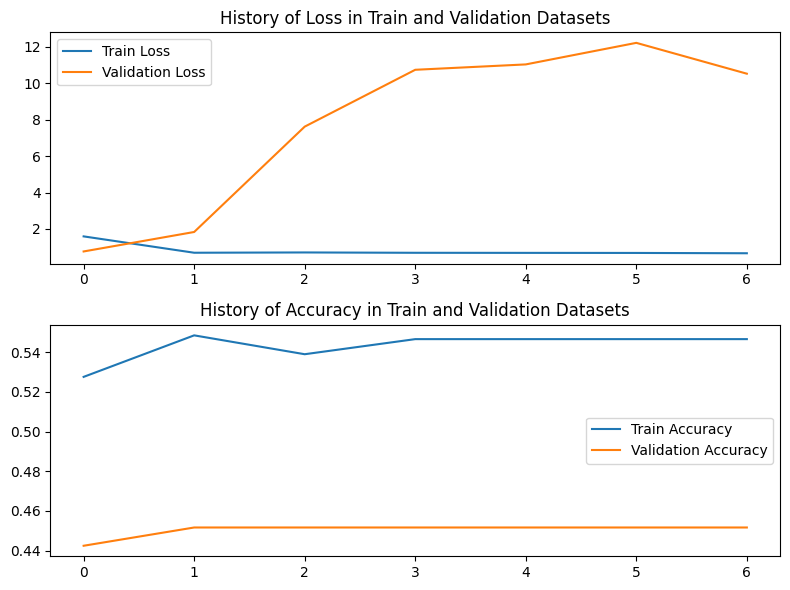

In [ ]:
plot_training(training_history,'cnn_train_plot')

In [ ]:
def test_data_generator(data_dir, zoom_range=0.2, shear_range=0.2, horizontal_flip=True):

    datagen = image.ImageDataGenerator(
        rescale=1./255
    )

    return datagen.flow_from_directory(
        directory=data_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary',
        shuffle=False,
        # class_weights=class_weights
    )

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image

def plot_confusion(y_true, y_pred, name, labels):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    save_fig(name)
    plt.show()


In [ ]:
def test_model(model, test_data, BATCH_SIZE, labels):

    predictions = model.predict(test_data)
    y_pred = np.round(predictions).reshape(-1)
    y_true = test_data.classes

    plot_confusion(y_true, y_pred, 'confusion_matrix', labels)

    test_loss, test_acc = model.evaluate(test_data, batch_size=BATCH_SIZE)

    return test_loss, test_acc

Found 130 images belonging to 2 classes.
5/5 [==============================] - 0s 53ms/step
Saving figure confusion_matrix


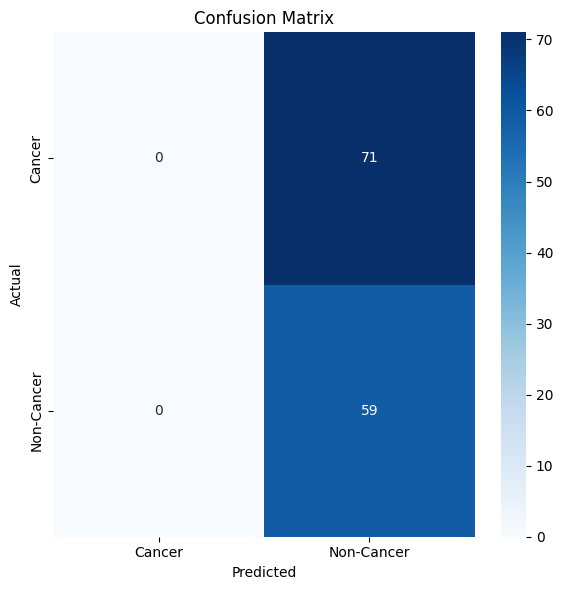

5/5 [==============================] - 0s 44ms/step - loss: 10.4099 - accuracy: 0.4538
Test Loss: 10.409894943237305
Test Accuracy: 0.45384615659713745


In [ ]:
test_dir = "splitted_dataset/test"
BATCH_SIZE = 32
labels = ['Cancer', 'Non-Cancer']

test_data = test_data_generator(test_dir)

test_loss, test_acc = test_model(cnn_model, test_data, BATCH_SIZE, labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
from tensorflow.keras.applications import VGG19

def create_vgg19_model(input_shape, num_classes):

    base_model = VGG19(weights='imagenet', include_top=True, input_shape=input_shape)

    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],)

    return model

def train_model_with_data_generators(model, train_dir, val_dir, epochs=32,class_weight=None):

    # Data Loaders
    train_datagen = image.ImageDataGenerator(rescale=1./255,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest")
    val_datagen = image.ImageDataGenerator( rescale=1./255,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest")

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_data = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    print("Train Data:")
    print("Found", train_data.samples, "images belonging to", len(train_data.class_indices), "classes.")
    print("Class Indices:", train_data.class_indices)
    print()

    print("Validation Data:")
    print("Found", val_data.samples, "images belonging to", len(val_data.class_indices), "classes.")
    print()

    mc = ModelCheckpoint(
        filepath="oral_cancer_best_model.keras",
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto'
    )
    callbacks = [mc]

    steps_per_epoch = ceil(train_data.samples / train_data.batch_size)
    validation_steps = ceil(val_data.samples / val_data.batch_size)

    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_data,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weight
    )

    return history




In [ ]:

input_shape = (224, 224, 3)
num_classes = 2
vgg19_model = create_vgg19_model(input_shape, num_classes)

epochs = 30
training_history2 = train_model_with_data_generators(vgg19_model, train_dir, val_dir, epochs=epochs)

Found 525 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Train Data:
Found 525 images belonging to 2 classes.
Class Indices: {'Cancer': 0, 'Non-Cancer': 1}

Validation Data:
Found 217 images belonging to 2 classes.

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5352
Epoch 1: val_accuracy improved from -inf to 0.54839, saving model to oral_cancer_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 31s 1s/step - loss: 0.6915 - accuracy: 0.5352 - val_loss: 0.6887 - val_accuracy: 0.5484
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5467
Epoch 2: val_accuracy did not improve from 0.54839
17/17 [==============================] - 11s 651ms/step - loss: 0.6892 - accuracy: 0.5467 - val_loss: 0.6878 - val_accuracy: 0.5484
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.5467
Epoch 3: val_accuracy did not improve from 0.54839
17/17 [==============================] - 11s 672ms/step - loss: 0.6886 - accuracy: 0.5467 - val_loss: 0.6870 - val_accuracy: 0.5484
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5467
Epoch 4: val_accuracy did not improve from 0.54839
17/17 [==============================] - 9s 562ms/step - loss: 0.6883 - accuracy: 0.5467 - val_loss: 0.6864 - val_accuracy: 0.5484
Epoch 5/30
17/17 [=======================

Saving figure vgg_train_plot


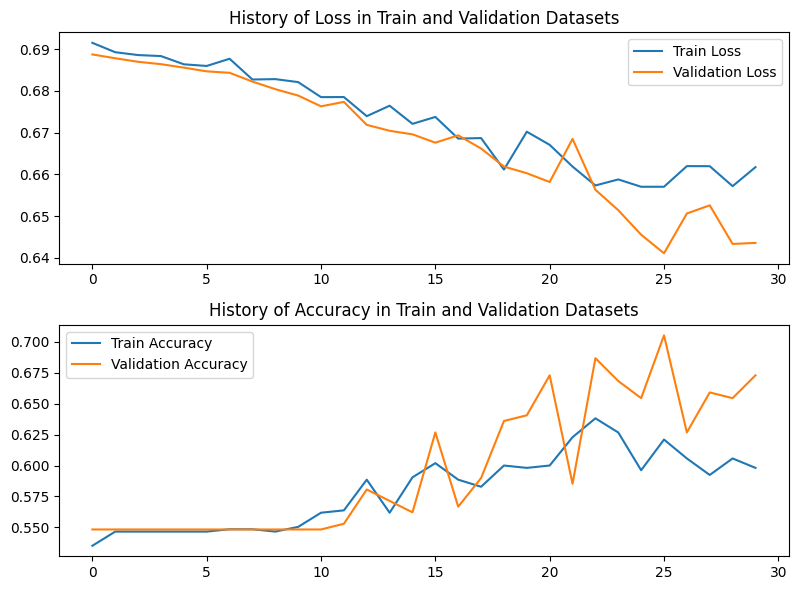

In [ ]:
plot_training(training_history2,'vgg_train_plot')

Found 130 images belonging to 2 classes.
5/5 [==============================] - 2s 453ms/step
Saving figure confusion_matrix


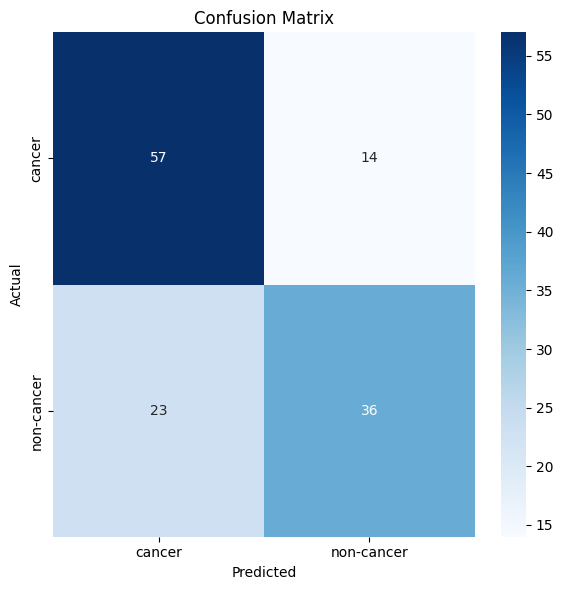

5/5 [==============================] - 1s 115ms/step - loss: 0.6127 - accuracy: 0.7154
Test Loss: 0.6127317547798157
Test Accuracy: 0.7153846025466919


In [ ]:
test_dir = "splitted_dataset/test"
BATCH_SIZE = 32
labels = ['cancer', 'non-cancer']

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle= False)


test_loss, test_acc = test_model(vgg19_model, test_data, BATCH_SIZE, labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=True, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1, activation= 'sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
input_shape = (224, 224, 3)
num_classes = 2
densenet_model = create_densenet_model(input_shape, num_classes)

epochs = 30
training_history2 = train_model_with_data_generators(densenet_model, train_dir, val_dir, epochs=epochs)

Found 525 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Train Data:
Found 525 images belonging to 2 classes.
Class Indices: {'Cancer': 0, 'Non-Cancer': 1}

Validation Data:
Found 217 images belonging to 2 classes.

Epoch 1/30
33/33 [==============================] - 30s 694ms/step - loss: 0.6890 - accuracy: 0.5486 - val_loss: 0.6833 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 2/30
33/33 [==============================] - 15s 468ms/step - loss: 0.6805 - accuracy: 0.5467 - val_loss: 0.6749 - val_accuracy: 0.5576 - lr: 0.0010
Epoch 3/30
33/33 [==============================] - 15s 472ms/step - loss: 0.6731 - accuracy: 0.5543 - val_loss: 0.6676 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 4/30
33/33 [==============================] - 17s 513ms/step - loss: 0.6661 - accuracy: 0.6000 - val_loss: 0.6581 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 5/30
33/33 [==============================] - 16s 479ms/step - loss: 0.6611 - accuracy: 0.6114 - val_loss: 0.6510 - val_accuracy:

Saving figure densenet_train_plot


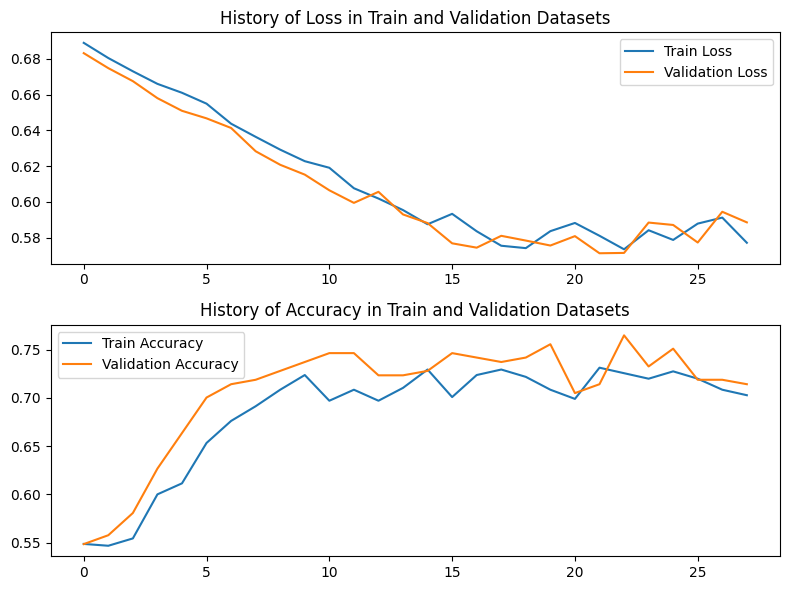

In [ ]:
plot_training(training_history2,'densenet_train_plot')

Found 130 images belonging to 2 classes.
5/5 [==============================] - 9s 599ms/step
Saving figure confusion_matrix


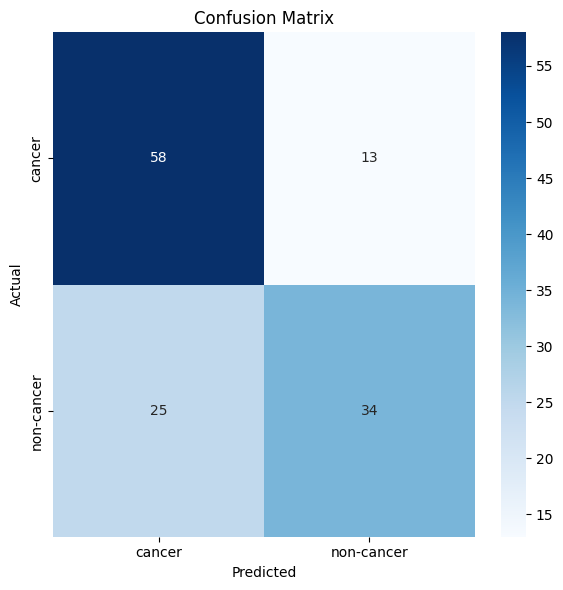

5/5 [==============================] - 1s 82ms/step - loss: 0.5783 - accuracy: 0.7077
Test Loss: 0.5782903432846069
Test Accuracy: 0.7076923251152039


In [ ]:
test_dir = "splitted_dataset/test"
BATCH_SIZE = 32
labels = ['cancer', 'non-cancer']

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle= False)


test_loss, test_acc = test_model(densenet_model, test_data, BATCH_SIZE, labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
input_shape = (224, 224, 3)
num_classes = 2
densenet_model = create_densenet_model(input_shape, num_classes)

epochs = 50
training_history2 = train_model_with_data_generators(densenet_model, train_dir, val_dir, epochs=epochs)

Found 525 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Train Data:
Found 525 images belonging to 2 classes.
Class Indices: {'Cancer': 0, 'Non-Cancer': 1}

Validation Data:
Found 217 images belonging to 2 classes.

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5467
Epoch 1: val_accuracy improved from -inf to 0.55300, saving model to oral_cancer_best_model.keras
17/17 [==============================] - 21s 913ms/step - loss: 0.6910 - accuracy: 0.5467 - val_loss: 0.6883 - val_accuracy: 0.5530
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.5429
Epoch 2: val_accuracy did not improve from 0.55300
17/17 [==============================] - 11s 679ms/step - loss: 0.6863 - accuracy: 0.5429 - val_loss: 0.6828 - val_accuracy: 0.5484
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5562
Epoch 3: val_accuracy improved from 0.55300 to 0.55760, saving m

Saving figure densenet_train_plot


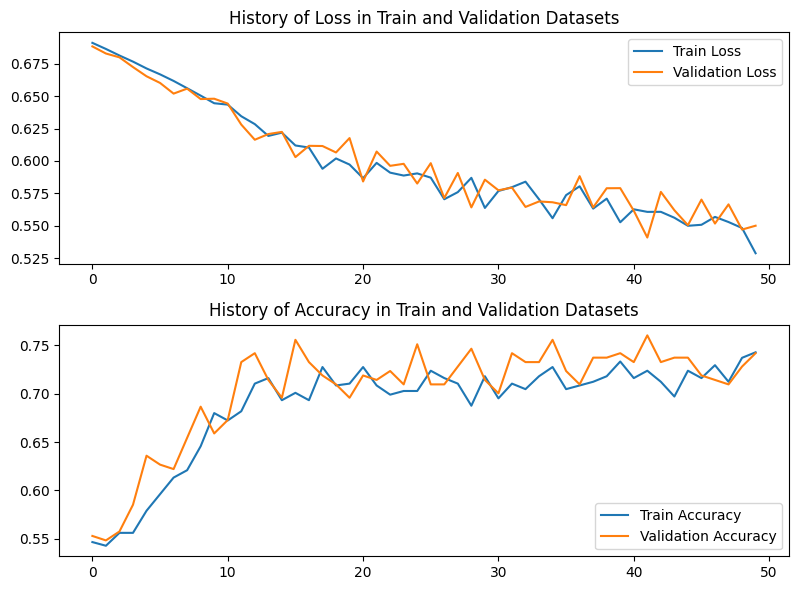

In [ ]:
plot_training(training_history2,'densenet_train_plot')

Found 130 images belonging to 2 classes.
5/5 [==============================] - 11s 648ms/step
Saving figure confusion_matrix


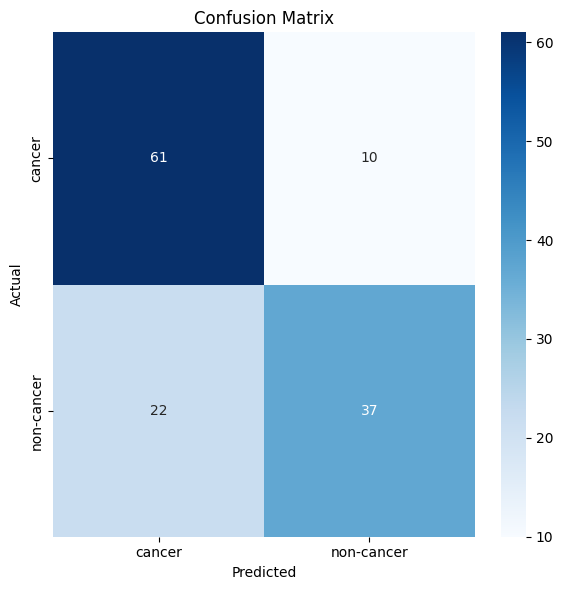

5/5 [==============================] - 0s 75ms/step - loss: 0.5127 - accuracy: 0.7538
Test Loss: 0.5127166509628296
Test Accuracy: 0.7538461685180664


In [ ]:
test_dir = "splitted_dataset/test"
BATCH_SIZE = 32
labels = ['cancer', 'non-cancer']

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle= False)


test_loss, test_acc = test_model(densenet_model, test_data, BATCH_SIZE, labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_precision_recall_f1(history, model):

    true_labels = test_data.classes
    predictions = model.predict(test_data)
    predicted_labels = np.round(predictions).reshape(-1)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [ ]:
print_precision_recall_f1(training_history2,densenet_model)

5/5 [==============================] - 1s 105ms/step
Precision: 0.7872340425531915
Recall: 0.6271186440677966
F1 Score: 0.6981132075471698
